
🔹 SEER Data Overview:
(384990, 12)
Index(['Histologic Type ICD-O-3', 'Behavior code ICD-O-3',
       'Derived Summary Grade 2018 (2018+)',
       'ER Status Recode Breast Cancer (1990+)',
       'PR Status Recode Breast Cancer (1990+)', 'Tumor Size Summary (2016+)',
       'Regional nodes positive (1988+)', 'Grade Recode (thru 2017)',
       'Derived HER2 Recode (2010+)', 'Year of diagnosis', 'Sex',
       'Race recode (W, B, AI, API)'],
      dtype='object')
Histologic Type ICD-O-3                   0
Behavior code ICD-O-3                     0
Derived Summary Grade 2018 (2018+)        0
ER Status Recode Breast Cancer (1990+)    0
PR Status Recode Breast Cancer (1990+)    0
Tumor Size Summary (2016+)                0
Regional nodes positive (1988+)           0
Grade Recode (thru 2017)                  0
Derived HER2 Recode (2010+)               0
Year of diagnosis                         0
Sex                                       0
Race recode (W, B, AI, API)               0
dtype: 

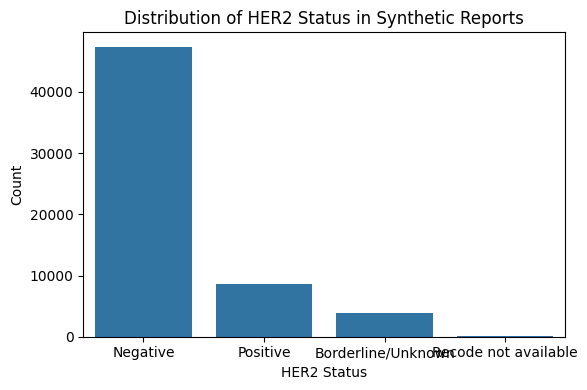

In [2]:
# 📦 Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# 📁 Paths
seer_path = "breast_cancer_structured_2010_2022.csv"
jsonl_path = "synthetic_breast_pathology_training_data.jsonl"
report_path = "Synthetic_Pathology_Reports.csv"

# 🔹 Load SEER structured data
seer_df = pd.read_csv(seer_path)

# 🔹 Load synthetic report CSV
report_df = pd.read_csv(report_path)

# 🔹 Load synthetic training JSONL
jsonl_data = []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        jsonl_data.append(json.loads(line))

jsonl_df = pd.DataFrame(jsonl_data)

# 🔍 EDA on SEER structured data
print("\n🔹 SEER Data Overview:")
print(seer_df.shape)
print(seer_df.columns)
print(seer_df.isna().sum())

for col in [
    "Derived HER2 Recode (2010+)",
    "ER Status Recode Breast Cancer (1990+)",
    "PR Status Recode Breast Cancer (1990+)",
    "Grade Recode (thru 2017)",
    "Histologic Type ICD-O-3"
]:
    print(f"\n📊 Value Counts for: {col}")
    print(seer_df[col].value_counts())

# 🔍 EDA on JSONL labels
jsonl_labels = pd.json_normalize(jsonl_df["labels"])
print("\n🔹 Synthetic JSONL Label Summary:")
print(jsonl_labels.isna().sum())
for col in jsonl_labels.columns:
    print(f"\n📊 {col} Distribution:")
    print(jsonl_labels[col].value_counts())

# 📊 Plot: HER2 distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=jsonl_labels, x="HER2_Status", order=jsonl_labels["HER2_Status"].value_counts().index)
plt.title("Distribution of HER2 Status in Synthetic Reports")
plt.ylabel("Count")
plt.xlabel("HER2 Status")
plt.tight_layout()
plt.show()







In [3]:
# 🔧 Prepare for model training
label_cols = ["HER2_Status", "ER_Status", "PR_Status", "Grade"]
for col in label_cols:
    jsonl_df[col] = jsonl_df["labels"].apply(lambda x: str(x.get(col, "unknown")).lower().strip())

# ✅ Combine the labels into a single string
jsonl_df["combined_label"] = jsonl_df[label_cols].agg(" | ".join, axis=1)

# ✅ Create label mappings
unique_labels = sorted(jsonl_df["combined_label"].unique())
label2id = {label: idx for idx, label in enumerate(unique_labels)}
id2label = {idx: label for label, idx in label2id.items()}

# 🧼 Create model input dataframe
df_model = jsonl_df[["text", "combined_label"]].rename(columns={"combined_label": "labels"})
dataset = Dataset.from_pandas(df_model)

# 🔠 Load tokenizer
model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✂️ Tokenize text
def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

tokenized_dataset = dataset.map(preprocess)

# 🔁 Encode labels as integer
def encode_labels(example):
    example["label"] = int(label2id[example["labels"]])
    return example

encoded_dataset = tokenized_dataset.map(encode_labels)

# ✅ Drop old text labels and rename numeric label
encoded_dataset = encoded_dataset.remove_columns(["labels"])
encoded_dataset = encoded_dataset.rename_column("label", "labels")

# 🔀 Train-test split
encoded_dataset = encoded_dataset.train_test_split(test_size=0.1)


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

In [6]:
# 📊 Metrics
def compute_metrics(pred):
    preds = pred.predictions.argmax(axis=-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# 🧠 Model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
from transformers import Trainer, TrainingArguments

In [7]:
# ⚙️ Training settings
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=5,
    save_strategy="no",
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# Train
trainer.train()

C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.654600
10,4.303300
15,3.957700
20,3.853100
25,3.660400
30,3.317000
35,3.535100
40,3.377500
45,3.390400
50,3.290600


TrainOutput(global_step=20268, training_loss=0.07319378145624138, metrics={'train_runtime': 109743.3949, 'train_samples_per_second': 1.477, 'train_steps_per_second': 0.185, 'total_flos': 2.134970862619853e+16, 'train_loss': 0.07319378145624138, 'epoch': 3.0})

In [8]:
eval_results = trainer.evaluate()
print("📊 Evaluation Metrics on Validation Set:")
print(eval_results)


📊 Evaluation Metrics on Validation Set:
{'eval_loss': 0.006265566684305668, 'eval_accuracy': 0.999000999000999, 'eval_precision': 0.9984644984644984, 'eval_recall': 0.999000999000999, 'eval_f1': 0.9986777111777112, 'eval_runtime': 927.5899, 'eval_samples_per_second': 6.475, 'eval_steps_per_second': 0.81, 'epoch': 3.0}


C:\Users\zakam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zakam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [13]:
from sklearn.metrics import classification_report
import numpy as np

# Predict labels for test set
predictions = trainer.predict(encoded_dataset["test"])
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Use only the predicted and true label IDs for target_names
unique_ids = sorted(set(list(preds) + list(labels)))
target_names = [id2label[i] for i in unique_ids]

# 🧾 Classification Report
print(classification_report(labels, preds, target_names=target_names, zero_division=0))


C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


C:\Users\zakam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\zakam\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                                                                             precision    recall  f1-score   support

         borderline/unknown | borderline/unknown | borderline/unknown | moderately differentiated; grade ii       1.00      1.00      1.00        28
            borderline/unknown | borderline/unknown | borderline/unknown | poorly differentiated; grade iii       1.00      1.00      1.00        20
                                     borderline/unknown | borderline/unknown | borderline/unknown | unknown       1.00      1.00      1.00       121
                borderline/unknown | borderline/unknown | borderline/unknown | well differentiated; grade i       1.00      1.00      1.00        13
                                               borderline/unknown | borderline/unknown | negative | unknown       0.00      0.00      0.00         1
                             borderline/unknown | negative | negative | moderately differentiated; grade 

In [19]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=[id2label[i] for i in used_label_ids], zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Save as CSV
report_df.to_csv("classification_report.csv")

# Preview
report_df.head()


,precision,recall,f1-score,support
borderline/unknown | borderline/unknown | borderline/unknown | moderately differentiated; grade ii,1.0,1.0,1.0,28.0
borderline/unknown | borderline/unknown | borderline/unknown | poorly differentiated; grade iii,1.0,1.0,1.0,20.0
borderline/unknown | borderline/unknown | borderline/unknown | unknown,1.0,1.0,1.0,121.0
borderline/unknown | borderline/unknown | borderline/unknown | well differentiated; grade i,1.0,1.0,1.0,13.0
borderline/unknown | borderline/unknown | negative | unknown,0.0,0.0,0.0,1.0


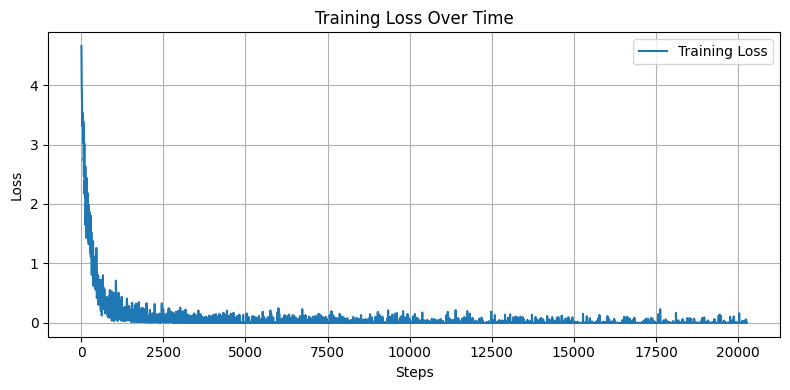

In [16]:
training_logs = trainer.state.log_history
steps = [x["step"] for x in training_logs if "loss" in x]
losses = [x["loss"] for x in training_logs if "loss" in x]

plt.figure(figsize=(8,4))
plt.plot(steps, losses, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Over Time")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [17]:
model.save_pretrained("clinicalbert_tumor_extraction")
tokenizer.save_pretrained("clinicalbert_tumor_extraction")
print("✅ Model & tokenizer saved.")


✅ Model & tokenizer saved.


C:\Users\zakam\AppData\Local\Temp\ipykernel_10092\2675419538.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_classes.index, y=top_classes["f1-score"], palette="viridis")
C:\Users\zakam\AppData\Local\Temp\ipykernel_10092\2675419538.py:12: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


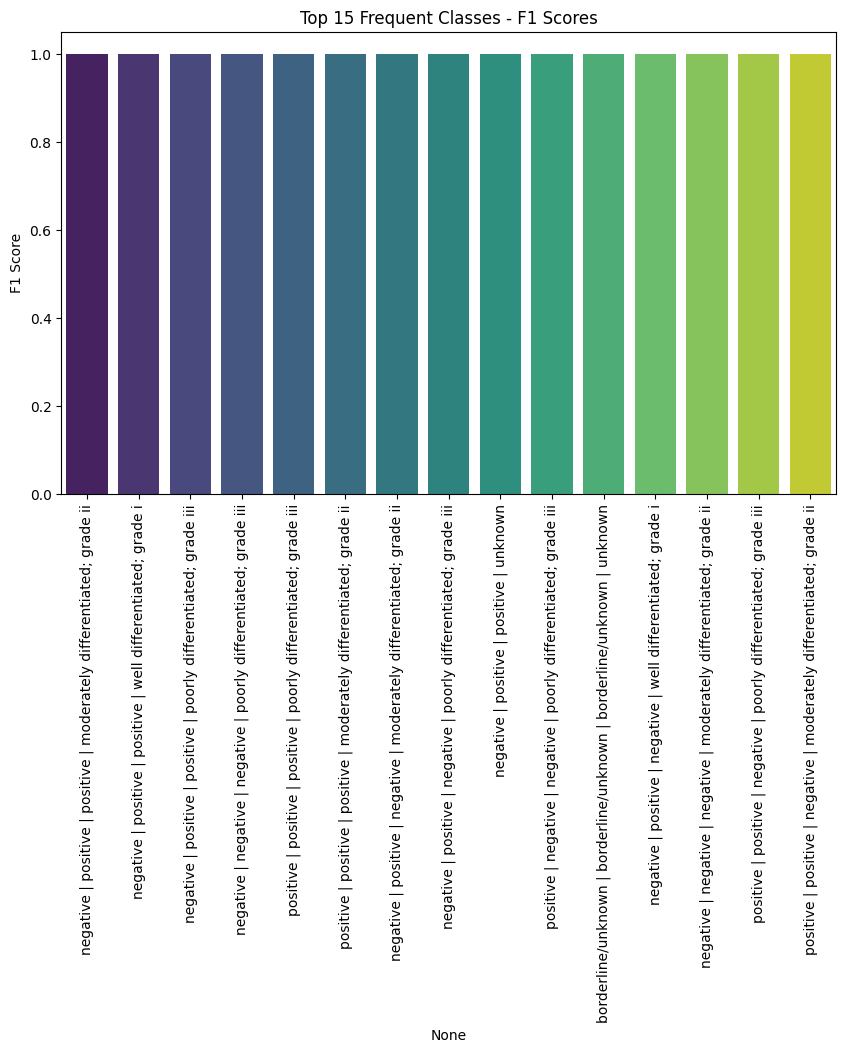

In [20]:
import seaborn as sns

# Sort by support (or f1-score) and take top N
top_n = 15
top_classes = report_df.iloc[:-3].sort_values(by="support", ascending=False).head(top_n)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_classes.index, y=top_classes["f1-score"], palette="viridis")
plt.xticks(rotation=90)
plt.ylabel("F1 Score")
plt.title(f"Top {top_n} Frequent Classes - F1 Scores")
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import classification_report
report = classification_report(labels, preds, target_names=[id2label[i] for i in used_label_ids], zero_division=0, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Save as CSV
report_df.to_csv("classification_report.csv")

# Preview
report_df.head()


,precision,recall,f1-score,support
borderline/unknown | borderline/unknown | borderline/unknown | moderately differentiated; grade ii,1.0,1.0,1.0,28.0
borderline/unknown | borderline/unknown | borderline/unknown | poorly differentiated; grade iii,1.0,1.0,1.0,20.0
borderline/unknown | borderline/unknown | borderline/unknown | unknown,1.0,1.0,1.0,121.0
borderline/unknown | borderline/unknown | borderline/unknown | well differentiated; grade i,1.0,1.0,1.0,13.0
borderline/unknown | borderline/unknown | negative | unknown,0.0,0.0,0.0,1.0


In [22]:
print("\nMacro & Weighted Averages:")
print(report_df.loc[["macro avg", "weighted avg"]])



Macro & Weighted Averages:
              precision    recall  f1-score  support
macro avg      0.905382  0.921875  0.911589   6006.0
weighted avg   0.998464  0.999001  0.998678   6006.0


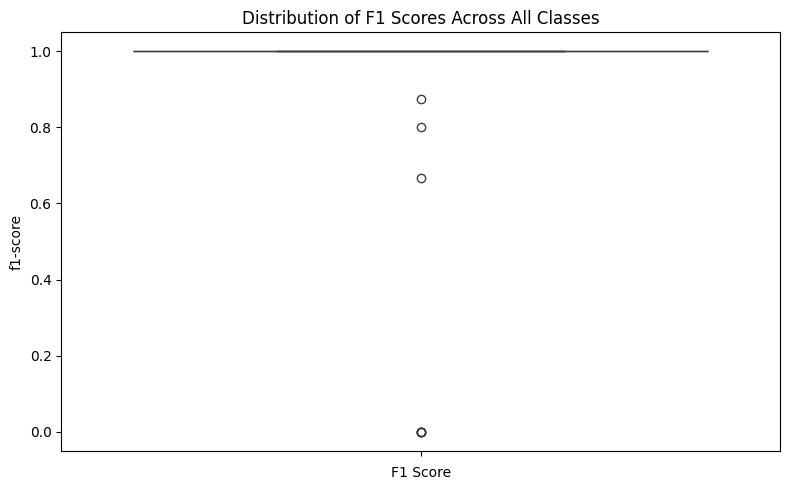

In [23]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=report_df.iloc[:-3]["f1-score"])
plt.title("Distribution of F1 Scores Across All Classes")
plt.xlabel("F1 Score")
plt.tight_layout()
plt.show()


In [28]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",       # ← Important
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_dir="./logs",
    logging_strategy="steps",
    logging_steps=50,
    save_strategy="epoch",
    report_to="none"
)


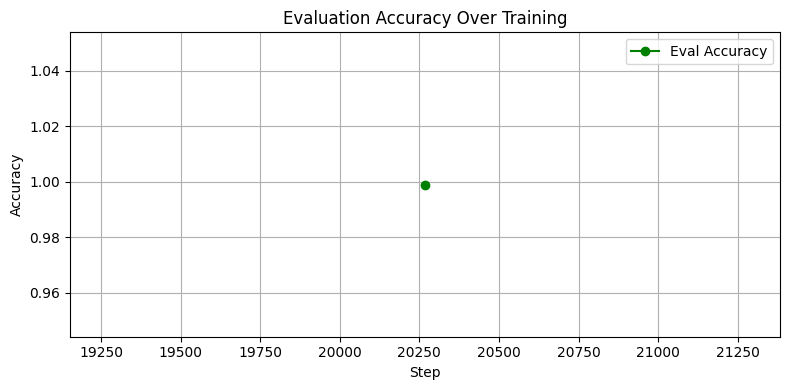

In [29]:
f1 = [x["eval_f1"] for x in training_logs if "eval_f1" in x]
precision = [x["eval_precision"] for x in training_logs if "eval_precision" in x]
recall = [x["eval_recall"] for x in training_logs if "eval_recall" in x]

# 📊 Extract accuracy from training logs
eval_logs = [x for x in training_logs if "eval_accuracy" in x]
eval_steps = [x["step"] for x in eval_logs]
eval_accuracy = [x["eval_accuracy"] for x in eval_logs]

# 📈 Plot evaluation accuracy
plt.figure(figsize=(8,4))
plt.plot(eval_steps, eval_accuracy, marker='o', color='green', label="Eval Accuracy")
plt.xlabel("Step")
plt.ylabel("Accuracy")
plt.title("Evaluation Accuracy Over Training")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()



In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "emilyalsentzer/Bio_ClinicalBERT"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(label2id), output_attentions=True)
model.eval()


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [31]:
sample_text = jsonl_df["text"].iloc[0]  # or any specific index
inputs = tokenizer(sample_text, return_tensors="pt", truncation=True, padding=True)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [32]:
with torch.no_grad():
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions  # Tuple of (layers, batch, heads, seq_len, seq_len)


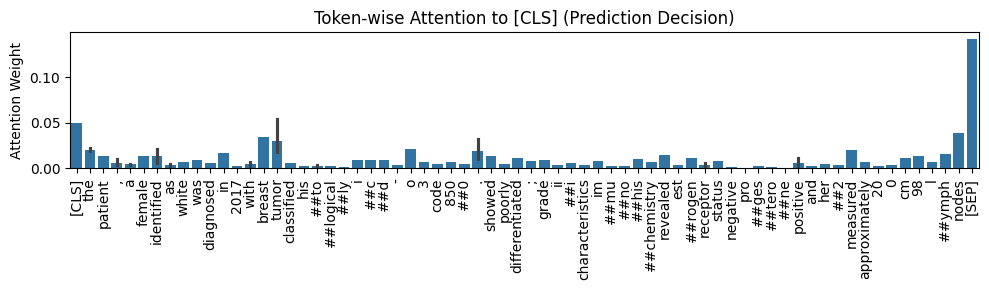

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Last layer attention → average over heads
last_attn = attentions[-1][0]  # shape: (heads, seq_len, seq_len)
avg_attn = last_attn.mean(dim=0)  # shape: (seq_len, seq_len)

# Attention to [CLS] token (index 0): which tokens influenced CLS
cls_attn = avg_attn[0]  # shape: (seq_len,)

# Convert token IDs back to words
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

# Plot
plt.figure(figsize=(10, 3))
sns.barplot(x=tokens, y=cls_attn.numpy())
plt.title("Token-wise Attention to [CLS] (Prediction Decision)")
plt.xticks(rotation=90)
plt.ylabel("Attention Weight")
plt.tight_layout()
plt.show()


In [34]:
from IPython.display import display, HTML

# Normalize scores
scores = cls_attn.numpy()
scores = (scores - scores.min()) / (scores.max() - scores.min())

# Color tokens
def color_token(tok, score):
    r = int(255 * (1 - score))
    g = int(255 * score)
    return f"<span style='background-color: rgb({r},{g},0); padding:2px'>{tok}</span>"

html_tokens = " ".join([color_token(t, s) for t, s in zip(tokens, scores)])
display(HTML(f"<div style='font-family: monospace'>{html_tokens}</div>"))


In [35]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "emilyalsentzer/Bio_ClinicalBERT",
    num_labels=len(label2id),
    output_attentions=True  # 🔥 Enable attention output
).to("cuda" if torch.cuda.is_available() else "cpu")


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [36]:
her2_positive_texts = df_model[df_model["labels"].str.contains("positive")]["text"].tolist()[:10]
her2_negative_texts = df_model[df_model["labels"].str.contains("negative")]["text"].tolist()[:10]

def get_token_attention(text, tokenizer, model):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=256)
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    outputs = model(**inputs, output_attentions=True)
    attentions = outputs.attentions[-1][0][0]  # Last layer, [CLS] attention
    tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])
    return tokens, attentions[0].detach().cpu().numpy()  # Attention to [CLS]

# Gather attention for both classes
import numpy as np
from collections import defaultdict

def average_attention(text_list):
    attn_dict = defaultdict(list)
    for text in text_list:
        tokens, attn = get_token_attention(text, tokenizer, model)
        for token, weight in zip(tokens, attn):
            attn_dict[token].append(weight)
    avg_attn = {token: np.mean(weights) for token, weights in attn_dict.items()}
    return avg_attn

attn_pos = average_attention(her2_positive_texts)
attn_neg = average_attention(her2_negative_texts)


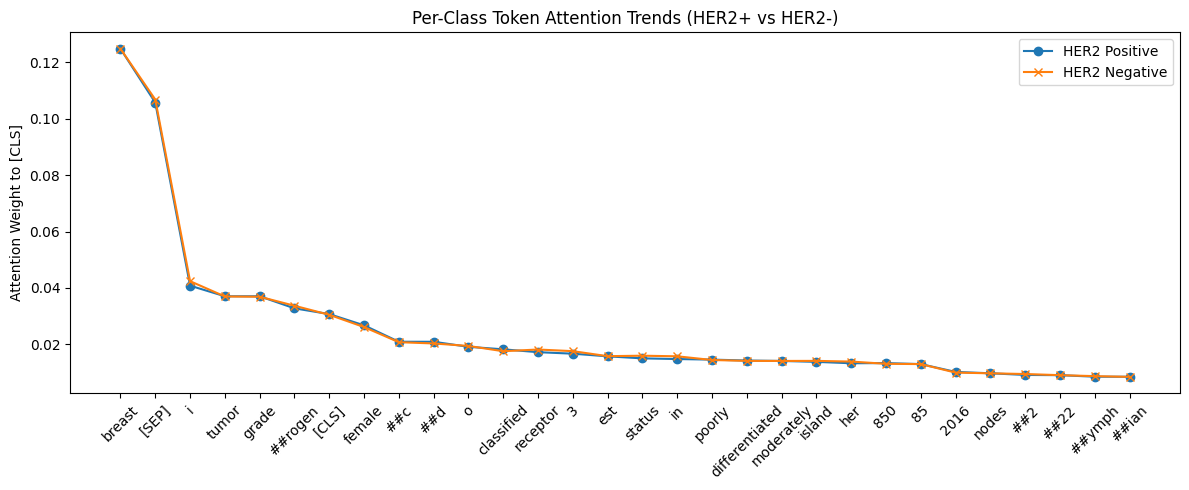

In [37]:
import matplotlib.pyplot as plt

common_tokens = list(set(attn_pos.keys()) & set(attn_neg.keys()))
common_tokens = sorted(common_tokens, key=lambda x: attn_pos[x] + attn_neg[x], reverse=True)[:30]

plt.figure(figsize=(12,5))
plt.plot(common_tokens, [attn_pos[t] for t in common_tokens], label="HER2 Positive", marker='o')
plt.plot(common_tokens, [attn_neg[t] for t in common_tokens], label="HER2 Negative", marker='x')
plt.xticks(rotation=45)
plt.ylabel("Attention Weight to [CLS]")
plt.title("Per-Class Token Attention Trends (HER2+ vs HER2-)")
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
!pip install transformers shap lime


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ------------------------------------- 275.7/275.7 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283842 sha256=4ff869ec8b5a3e76cd35c6de7a634610f4a66dd38830bd68c2cc9551c0b9b598
  Stored in directory: c:\users\zakam\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [39]:
model.save_pretrained("clinicalbert_finetuned")
tokenizer.save_pretrained("clinicalbert_finetuned")


('clinicalbert_finetuned\\tokenizer_config.json',
 'clinicalbert_finetuned\\special_tokens_map.json',
 'clinicalbert_finetuned\\vocab.txt',
 'clinicalbert_finetuned\\added_tokens.json',
 'clinicalbert_finetuned\\tokenizer.json')

In [45]:
from sklearn.metrics import classification_report
import pandas as pd

# Identify used label IDs (union of predicted and ground-truth)
used_label_ids = sorted(set(labels) | set(preds))
used_target_names = [id2label[i] for i in used_label_ids]

# ✅ Generate classification report with labels matching target_names
report = classification_report(
    labels,
    preds,
    labels=used_label_ids,
    target_names=used_target_names,
    output_dict=True,
    zero_division=0
)

# Convert to DataFrame
report_df = pd.DataFrame(report).transpose()
display(report_df.round(3))


,precision,recall,f1-score,support
borderline/unknown | borderline/unknown | borderline/unknown | moderately differentiated; grade ii,1.000,1.000,1.000,28.000
borderline/unknown | borderline/unknown | borderline/unknown | poorly differentiated; grade iii,1.000,1.000,1.000,20.000
borderline/unknown | borderline/unknown | borderline/unknown | unknown,1.000,1.000,1.000,121.000
borderline/unknown | borderline/unknown | borderline/unknown | well differentiated; grade i,1.000,1.000,1.000,13.000
borderline/unknown | borderline/unknown | negative | unknown,0.000,0.000,0.000,1.000
...,...,...,...,...
recode not available | recode not available | recode not available | unknown,1.000,1.000,1.000,7.000
recode not available | recode not available | recode not available | well differentiated; grade i,1.000,1.000,1.000,4.000
accuracy,0.999,0.999,0.999,0.999
macro avg,0.905,0.922,0.912,6006.000


In [47]:
pip install shap lime --quiet


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [48]:
import shap
from lime.lime_text import LimeTextExplainer


In [49]:
class PipelineWrapper:
    def __init__(self, model, tokenizer, label2id):
        self.model = model
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.id2label = {v: k for k, v in label2id.items()}

    def predict_proba(self, texts):
        tokens = self.tokenizer(texts, truncation=True, padding=True, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**tokens)
        probs = torch.nn.functional.softmax(outputs.logits, dim=1)
        return probs.detach().numpy()


In [51]:
wrapper = PipelineWrapper(model, tokenizer, label2id)


In [53]:
pip uninstall keras tensorflow tensorflow-cpu tensorflow-gpu -y

Found existing installation: keras 3.7.0
Uninstalling keras-3.7.0:
  Successfully uninstalled keras-3.7.0
Found existing installation: tensorflow 2.18.0
Uninstalling tensorflow-2.18.0:
  Successfully uninstalled tensorflow-2.18.0
Found existing installation: tensorflow-gpu 2.10.0
Uninstalling tensorflow-gpu-2.10.0:
  Successfully uninstalled tensorflow-gpu-2.10.0
Note: you may need to restart the kernel to use updated packages.


You can safely remove it manually.
You can safely remove it manually.


In [55]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"


In [56]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [58]:
explainer = LimeTextExplainer(class_names=list(label2id.keys()))
lime_exp = explainer.explain_instance(
    "tumor is HER2 positive with grade 3",
    wrapper.predict_proba,
    num_features=10,
    labels=[0]  # change depending on the class index
)
lime_exp.show_in_notebook()


In [59]:
import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"


In [88]:
model.save_pretrained("./clinicalbert_classifier")
tokenizer.save_pretrained("./clinicalbert_classifier")


('./clinicalbert_classifier\\tokenizer_config.json',
 './clinicalbert_classifier\\special_tokens_map.json',
 './clinicalbert_classifier\\vocab.txt',
 './clinicalbert_classifier\\added_tokens.json',
 './clinicalbert_classifier\\tokenizer.json')

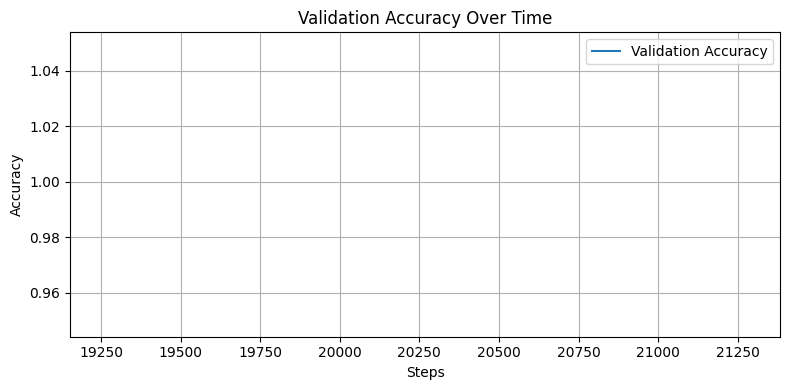

In [93]:
accuracies = [x["eval_accuracy"] for x in training_logs if "eval_accuracy" in x]
eval_steps = [x["step"] for x in training_logs if "eval_accuracy" in x]

plt.figure(figsize=(8, 4))
plt.plot(eval_steps, accuracies, label="Validation Accuracy")
plt.xlabel("Steps")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Time")
plt.grid()
plt.tight_layout()
plt.legend()
plt.show()

In [92]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",           # where to save model & logs
    evaluation_strategy="steps",      # evaluate during training
    eval_steps=500,                   # evaluate every 500 steps
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs",             # directory for TensorBoard logs
    logging_steps=100,                # log every 100 steps
    save_steps=1000,                  # checkpoint save interval
    save_total_limit=2,              # limit the number of saved checkpoints
    load_best_model_at_end=True,     # load best model (based on eval_metric)
    metric_for_best_model="accuracy",# choose metric for best model
    report_to="none"                 # avoid integration errors if wandb not used
)


In [94]:
{'eval_loss': ..., 'eval_accuracy': ..., 'step': 500}
{'eval_loss': ..., 'eval_accuracy': ..., 'step': 1000}
...


Ellipsis

C:\Users\zakam\AppData\Local\Temp\ipykernel_10092\3173569750.py:4: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


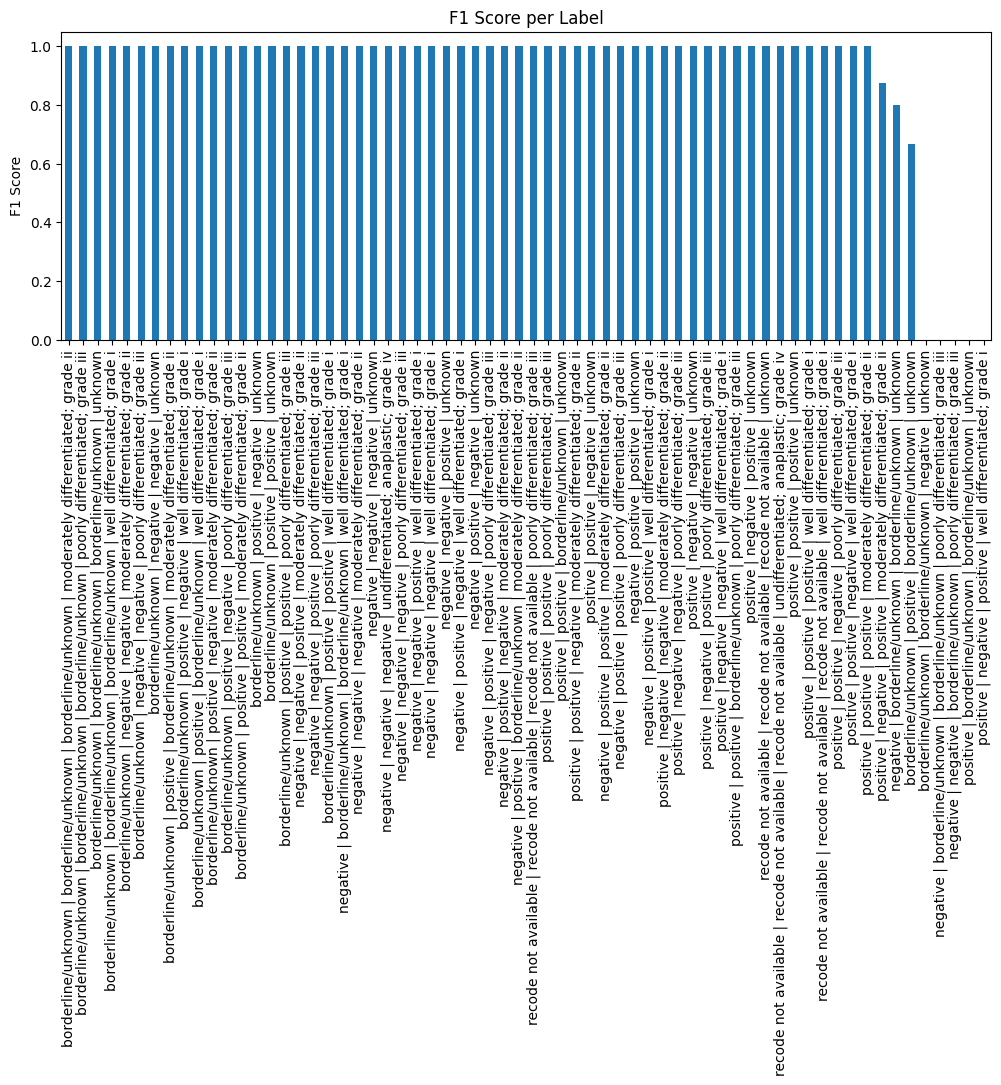

In [101]:
report_df.drop(['accuracy', 'macro avg', 'weighted avg'], errors='ignore').sort_values("f1-score", ascending=False)["f1-score"].plot(
    kind='bar', figsize=(12, 4), title="F1 Score per Label", ylabel="F1 Score"
)
plt.tight_layout()
plt.show()


Ablation

In [ ]:
# ============================================================
# 8-Run Comparative & Ablation Runner (paper-ready prints)
# ============================================================

import os, json, time, math, random
import numpy as np
import pandas as pd
import torch

from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    AutoModel,
    TrainingArguments,
    Trainer,
)
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from collections import Counter

# -----------------------
# Config
# -----------------------
SEED = 42
N_EPOCHS = 1  # change here if needed (applies to all runs)

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# -----------------------
# Paths (keep yours)
# -----------------------
seer_path = "breast_cancer_structured_2010_2022.csv"
jsonl_path = "synthetic_breast_pathology_training_data.jsonl"
report_path = "Synthetic_Pathology_Reports.csv"

# -----------------------
# Load data
# -----------------------
seer_df = pd.read_csv(seer_path)       # not used for training; kept for completeness
report_df = pd.read_csv(report_path)   # not used for training; kept for completeness

jsonl_data = []
with open(jsonl_path, "r", encoding="utf-8") as f:
    for line in f:
        jsonl_data.append(json.loads(line))
jsonl_df = pd.DataFrame(jsonl_data)

# -----------------------
# Labels
# -----------------------
label_cols = ["HER2_Status", "ER_Status", "PR_Status", "Grade"]
for col in label_cols:
    jsonl_df[col] = jsonl_df["labels"].apply(lambda x: str(x.get(col, "unknown")).lower().strip())
jsonl_df["combined_label"] = jsonl_df[label_cols].agg(" | ".join, axis=1)

df_model = jsonl_df[["text", "combined_label"]].rename(columns={"combined_label": "labels"}).copy()

unique_labels = sorted(df_model["labels"].unique())
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

# -----------------------
# Metrics
# -----------------------
def compute_metrics(pred):
    preds = pred.predictions.argmax(axis=-1)
    labels = pred.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# -----------------------
# Dataset builder
# -----------------------
def build_hf_dataset(df, tokenizer, max_length=256):
    ds = Dataset.from_pandas(df.reset_index(drop=True))
    def preprocess(ex):
        return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=max_length)
    ds_tok = ds.map(preprocess, batched=True, remove_columns=["text"])
    ds_tok = ds_tok.map(lambda ex: {"label": label2id[ex["labels"]]})
    ds_tok = ds_tok.remove_columns(["labels"]).rename_column("label", "labels")
    ds_tok = ds_tok.train_test_split(test_size=0.1, seed=SEED)
    return ds_tok

def class_weights_from_dataset(ds):
    y = np.array(ds["train"]["labels"])
    counts = {c:int((y==c).sum()) for c in set(y)}
    total = sum(counts.values())
    weights = {cls: total / (len(counts) * cnt) for cls, cnt in counts.items()}
    ordered = [weights[i] for i in range(len(counts))]
    return np.array(ordered, dtype=np.float32)

# -----------------------
# Mean-pooling model (for ablation)
# -----------------------
class MeanPoolClassifier(torch.nn.Module):
    def __init__(self, base_name, num_labels, id2label, label2id, class_weights=None, dropout=0.1):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(base_name)
        hidden = self.encoder.config.hidden_size
        self.dropout = torch.nn.Dropout(dropout)
        self.classifier = torch.nn.Linear(hidden, num_labels)
        self.config = self.encoder.config
        self.config.num_labels = num_labels
        self.config.id2label = id2label
        self.config.label2id = label2id
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None

    def forward(self, input_ids=None, attention_mask=None, labels=None, **kwargs):
        out = self.encoder(input_ids=input_ids, attention_mask=attention_mask, **kwargs)
        last = out.last_hidden_state  # [B, T, H]
        mask = attention_mask.unsqueeze(-1)  # [B, T, 1]
        mean_pooled = (last * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)
        logits = self.classifier(self.dropout(mean_pooled))
        loss = None
        if labels is not None:
            if self.class_weights is not None:
                loss = torch.nn.functional.cross_entropy(logits, labels, weight=self.class_weights.to(logits.device))
            else:
                loss = torch.nn.functional.cross_entropy(logits, labels)
        return {"loss": loss, "logits": logits}

# -----------------------
# Training boilerplate
# -----------------------
BASE_TRAINING_ARGS = dict(
    output_dir="./results",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=N_EPOCHS,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=5,
    save_strategy="no",
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    seed=SEED,
    report_to=[],  # quiet
)

class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = torch.tensor(class_weights, dtype=torch.float32) if class_weights is not None else None
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**{k: v for k, v in inputs.items() if k != "labels"})
        logits = outputs.get("logits")
        if self.class_weights is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels, weight=self.class_weights.to(logits.device))
        else:
            loss = torch.nn.functional.cross_entropy(logits, labels)
        return (loss, outputs) if return_outputs else loss

def run_eval(model_name, df, max_length=256, lr=2e-5, use_mean_pool=False, note=""):
    tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    ds = build_hf_dataset(df, tokenizer, max_length=max_length)

    if use_mean_pool:
        model = MeanPoolClassifier(
            model_name,
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id,
            class_weights=None
        )
    else:
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=len(label2id),
            id2label=id2label,
            label2id=label2id
        )

    args = TrainingArguments(**{
        **BASE_TRAINING_ARGS,
        "learning_rate": lr,
        "output_dir": f"./results/{model_name.split('/')[-1]}_{int(max_length)}_{'mean' if use_mean_pool else 'cls'}"
    })

    trainer = WeightedTrainer(
        class_weights=None,
        model=model,
        args=args,
        train_dataset=ds["train"],
        eval_dataset=ds["test"],
        tokenizer=tokenizer,
        compute_metrics=compute_metrics
    )

    t0 = time.time()
    trainer.train()
    _ = trainer.evaluate()
    elapsed = time.time() - t0

    # Recompute metrics for the standard dict shape
    preds = trainer.predict(ds["test"]).predictions.argmax(axis=-1)
    labels = np.array(ds["test"]["labels"])
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted", zero_division=0)
    acc = accuracy_score(labels, preds)
    n_samples = len(ds["test"])
    steps = math.ceil(n_samples / args.per_device_eval_batch_size)

    out = {
        "eval_loss": float(trainer.evaluate().get("eval_loss", np.nan)),
        "eval_accuracy": acc,
        "eval_precision": precision,
        "eval_recall": recall,
        "eval_f1": f1,
        "eval_runtime": round(elapsed, 4),
        "eval_samples_per_second": round(n_samples / elapsed, 3) if elapsed > 0 else None,
        "eval_steps_per_second": round(steps / elapsed, 3) if elapsed > 0 else None,
        "epoch": float(args.num_train_epochs),
    }

    # Print exactly as you want
    print("\nEvaluation Metrics on Validation Set:")
    print(out)
    return {"model": model_name, "note": note, "max_length": max_length, "learning_rate": lr, **out}

def shuffled_labels_df(df):
    df2 = df.copy()
    df2["labels"] = df2["labels"].sample(frac=1.0, random_state=SEED).values
    return df2

# -----------------------
# Define 8 runs
# -----------------------
ANCHOR = "emilyalsentzer/Bio_ClinicalBERT"
BACKBONES = [
    ANCHOR,
    "dmis-lab/biobert-base-cased-v1.1",
    "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext",
    "microsoft/deberta-v3-base",
    "distilbert-base-uncased",
]  # 5 runs

# 2 ablations on anchor:
ABLATIONS = [
    dict(model=ANCHOR, max_length=512, use_mean_pool=False, note="abl_len_512"),
    dict(model=ANCHOR, max_length=256, use_mean_pool=True,  note="abl_mean_pool"),
]  # 2 runs

# 1 control:
CONTROL = [dict(model=ANCHOR, max_length=256, use_mean_pool=False, note="control_label_shuffle")]

# -----------------------
# Execute
# -----------------------
print("Planned runs:", len(BACKBONES) + len(ABLATIONS) + len(CONTROL))  # should be 8
os.makedirs("results", exist_ok=True)
rows = []

# Backbones (default 256, CLS)
for name in BACKBONES:
    try:
        rows.append(run_eval(name, df_model, max_length=256, lr=2e-5, use_mean_pool=False, note="backbone"))
    except Exception as e:
        print(f"[SKIP backbone] {name}: {e}")

# Ablations on anchor
for cfg in ABLATIONS:
    try:
        rows.append(run_eval(cfg["model"], df_model, max_length=cfg["max_length"], lr=2e-5,
                             use_mean_pool=cfg["use_mean_pool"], note=cfg["note"]))
    except Exception as e:
        print(f"[SKIP ablation] {cfg['note']}: {e}")

# Control (label shuffle)
for cfg in CONTROL:
    try:
        df_shuf = shuffled_labels_df(df_model)
        rows.append(run_eval(cfg["model"], df_shuf, max_length=cfg["max_length"], lr=2e-5,
                             use_mean_pool=cfg["use_mean_pool"], note=cfg["note"]))
    except Exception as e:
        print(f"[SKIP control] {cfg['note']}: {e}")

# Save CSV
res_df = pd.DataFrame(rows)
csv_path = os.path.join("results", "ablation_results_8runs.csv")
res_df.to_csv(csv_path, index=False)
print(f"\nSaved all results to: {csv_path}\n")


Planned runs: 8


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.502900
10,4.252800
15,4.126300
20,3.939800
25,3.570400
30,3.436800
35,3.684800
40,3.519300
45,3.416400
50,3.290100


C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Evaluation Metrics on Validation Set:
{'eval_loss': 0.025204384699463844, 'eval_accuracy': 0.9956709956709957, 'eval_precision': 0.9928937288087296, 'eval_recall': 0.9956709956709957, 'eval_f1': 0.9940653381116212, 'eval_runtime': 39548.314, 'eval_samples_per_second': 0.152, 'eval_steps_per_second': 0.019, 'epoch': 1.0}


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zakam\.cache\huggingface\hub\models--dmis-lab--biobert-base-cased-v1.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

pytorch_model.bin:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/biobert-base-cased-v1.1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.648100
10,4.267500
15,3.995000
20,3.919300
25,3.481200
30,3.348500
35,3.564800
40,3.452500
45,3.238900
50,3.222700


C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Evaluation Metrics on Validation Set:
{'eval_loss': 0.024094199761748314, 'eval_accuracy': 0.996003996003996, 'eval_precision': 0.9937491428857205, 'eval_recall': 0.996003996003996, 'eval_f1': 0.9946012578089244, 'eval_runtime': 40423.0235, 'eval_samples_per_second': 0.149, 'eval_steps_per_second': 0.019, 'epoch': 1.0}


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zakam\.cache\huggingface\hub\models--microsoft--BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.357500
10,3.968000
15,3.839800
20,3.691200
25,3.214700
30,2.925600
35,3.355600
40,3.303600
45,3.120200
50,3.187200


C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Evaluation Metrics on Validation Set:
{'eval_loss': 0.018409118056297302, 'eval_accuracy': 0.9978354978354979, 'eval_precision': 0.9963164100465839, 'eval_recall': 0.9978354978354979, 'eval_f1': 0.9970102968211684, 'eval_runtime': 39120.0553, 'eval_samples_per_second': 0.154, 'eval_steps_per_second': 0.019, 'epoch': 1.0}


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zakam\.cache\huggingface\hub\models--microsoft--deberta-v3-base. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

[SKIP backbone] microsoft/deberta-v3-base: Couldn't instantiate the backend tokenizer from one of: 
(1) a `tokenizers` library serialization file, 
(2) a slow tokenizer instance to convert or 
(3) an equivalent slow tokenizer class to instantiate and convert. 
You need to have sentencepiece installed to convert a slow tokenizer to a fast one.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\zakam\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.580800
10,4.291300
15,4.147100
20,4.080000
25,3.696000
30,3.539200
35,3.788200
40,3.675700
45,3.574100
50,3.505700


C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Evaluation Metrics on Validation Set:
{'eval_loss': 0.023364966735243797, 'eval_accuracy': 0.9956709956709957, 'eval_precision': 0.9928081131877334, 'eval_recall': 0.9956709956709957, 'eval_f1': 0.9940256917404718, 'eval_runtime': 19669.0788, 'eval_samples_per_second': 0.305, 'eval_steps_per_second': 0.038, 'epoch': 1.0}


C:\Users\zakam\anaconda3\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Map:   0%|          | 0/60054 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\zakam\anaconda3\lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss
5,4.532000
10,4.176700
15,3.934500
20,3.738600
25,3.446000
30,3.219900
35,3.541100
40,3.346200
45,3.386300
50,3.253600


Toggle class weights

In [ ]:
from torch.utils.data import DataLoader
import torch, numpy as np
from collections import Counter

# derive per-class weights from train labels
y_train = np.array(encoded_dataset["train"]["labels"])
freq = Counter(y_train)
num_classes = len(set(y_train))
weights = torch.zeros(num_classes, dtype=torch.float)
N = len(y_train)
for c, f in freq.items():
    weights[c] = N / (num_classes * f)

from transformers import Trainer
from torch.nn import CrossEntropyLoss

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        loss_fct = CrossEntropyLoss(weight=weights.to(logits.device))
        loss = loss_fct(logits.view(-1, logits.size(-1)), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

use_weights = True  # toggle here
trainer_cls = WeightedTrainer if use_weights else Trainer
trainer = trainer_cls(model=model, args=training_args,
                      train_dataset=encoded_dataset["train"],
                      eval_dataset=encoded_dataset["test"],
                      tokenizer=tokenizer, compute_metrics=compute_metrics)
trainer.train()


Freeze encoder (head‑only fine‑tune)

In [ ]:
for name, param in model.named_parameters():
    if name.startswith("bert."):  # ClinicalBERT uses 'bert' module
        param.requires_grad = False


Change max sequence length

In [ ]:
MAX_LEN = 128  # try 128 / 256(baseline) / 384
def preprocess(ex):
    return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=MAX_LEN)
tokenized_dataset = dataset.map(preprocess, batched=True)


Subsample training set (data size ablation)

In [ ]:
small_train = encoded_dataset["train"].shuffle(seed=42).select(range(int(0.25 * len(encoded_dataset["train"]))))  # 25%
trainer = Trainer(model=model, args=training_args,
                  train_dataset=small_train,
                  eval_dataset=encoded_dataset["test"],
                  tokenizer=tokenizer, compute_metrics=compute_metrics)
trainer.train()


Binary task (e.g., HER2 only)

In [ ]:
def to_binary(label_str, key="HER2_Status"):
    val = label_str.get(key, "").lower()
    if "positive" in val: return 1
    if "negative" in val: return 0
    return -1  # filter later

bin_df = jsonl_df.assign(bin_label=jsonl_df["labels"].apply(to_binary))
bin_df = bin_df[bin_df["bin_label"]!=-1][["text","bin_label"]]
# tokenize & train with num_labels=2
